## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import os
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math
from scipy.stats import norm
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS
#from helper import *

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6'
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
lumi = 23.02*1000
xsec = 48.

if data_year == 2022:
    fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    if k=='signal':
        signal_gen_weight = tree[k]["weight"].array()

signal_gen_yield = np.sum(signal_gen_weight)*lumi
print(signal_gen_yield)

for k, T in tree.items():
    branch_names = T.keys()

1118331.3125610352


In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
all_weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
sel_ev_post = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}

cscClusterNStation = {}
cscClusterDphi = {}
nCscClusters = {}

cscClusterNRechitMinus11 = {}
cscClusterNRechitPlus11 = {}
cscClusterNRechitMinus12 = {}
cscClusterNRechitPlus12 = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}

ME11_veto = {}
ME12_veto = {}
MB1_veto = {}

#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [4]:
category = 0#-1#0
category = 1
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = False
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

#plot_string+= "_exactly_2_csc_clusters_ME_veto"
#plot_string+= "_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd"
plot_string+= "_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [5]:
for a in branch_names:
    #if "MB1" in str(a):
    #    print(a)
    if "dtRechitClusterMaxStationRatio" in str(a):
        print(a)
    #if "atio" in str(a):
    #    print(a)

b'dtRechitClusterMaxStationRatio'


In [6]:
for k, T in tree.items():
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = jet_veto_csc
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_not(jet_veto_csc)       

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    
          
    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    #ME11 and ME12 veto
    ME11_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )      

       
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto[k],ME12_veto[k])
                                   ) 
    if do_HLT_eta_cut:
        sel_csccluster = np.logical_and(sel_csccluster,sel_trgCluster)
        
        
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    MB1_veto[k] = T.array('dtRechitClusterNHitStation1') == 0
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto[k])
        
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose
     
    
    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #If trigger:
    #We don't have correct trigger emulation in signal at the moment
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)

    #At least one pre-selected csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
           
########### BRANCHES ############

    
    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMet_dPhi[k] =  T.array('dtRechitCluster' + cluster_index + 'Met_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStationRatio[k] = T.array('dtRechitCluster' + cluster_index + 'MaxStationRatio')[sel_dtcluster][sel_ev[k]][:,:]
        
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[sel_csccluster][sel_ev[k]][:,:]
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
    
    cscClusterNRechitMinus11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNRechitPlus11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNRechitMinus12[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNRechitPlus12[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')[sel_csccluster][sel_ev[k]][:,:]

      
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
       
    sel_jetveto_dt[k] = jet_veto_dt[sel_dtcluster][sel_ev[k]][:,:]
    sel_muonveto_dt[k] = muon_veto_dt[sel_dtcluster][sel_ev[k]][:,:]        

    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
       
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    weight[k] = T.array('weight')[ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]
    
    all_weight[k] = T.array('weight')

    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

* Study delta phi with met
* Apply at least one csc cluster requirement
* Apply L1 plateau

# L1 plateau

In [7]:
first_in_tr1 = {}
first_in_tr2 = {}
first_in_tr3 = {}

sel_ev_pl = {}

for k in tree_keys:
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = first_in_ME22[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]
    

    first_in_tr1[k] = np.logical_and( cscClusterSize[k][:,0] >= 100, np.logical_and(cscClusterNStation[k][:,0]>=2, np.abs(cscClusterEta[k][:,0])<1.9))
    first_in_tr2[k] = np.logical_and( cscClusterSize[k][:,0] >= 200, np.logical_and(cscClusterNStation[k][:,0]==1, np.abs(cscClusterEta[k][:,0])<1.9))
    first_in_tr3[k] = np.logical_and( cscClusterSize[k][:,0] >= 500, np.abs(cscClusterEta[k][:,0])>=1.9)
 
    ME1_veto_cl_0 = (cscClusterNRechitMinus11[k][:,0]==0) & (cscClusterNRechitPlus11[k][:,0]==0) & (cscClusterNRechitMinus12[k][:,0]==0) & (cscClusterNRechitPlus12[k][:,0]==0)
    ME1_veto_cl_1 = (cscClusterNRechitMinus11[k][:,1]==0) & (cscClusterNRechitPlus11[k][:,1]==0) & (cscClusterNRechitMinus12[k][:,1]==0) & (cscClusterNRechitPlus12[k][:,1]==0)

    sel_ev_pl[k] = np.logical_and(sel_ev[k],first_in_plateau[k]) & ME1_veto_cl_0# & ME1_veto_cl_1
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), cscClusterPhi[k][:,1].flatten() ) )
        dEta_csc_csc[k] = (  cscClusterEta[k][:,0].flatten() - cscClusterEta[k][:,1].flatten() )
        dR_csc_csc[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), cscClusterEta[k][:,1].flatten(), cscClusterPhi[k][:,1].flatten() )
        dt_csc_csc[k]   = (  cscClusterTime[k][:,0].flatten() - cscClusterTime[k][:,1].flatten() )
        min_dphi = 1.8#.65
        sel_ev_post[k] = np.logical_and(sel_ev_pl[k],np.abs(dPhi_csc_csc[k])>min_dphi)
    if category==2:
        dPhi_csc_dt[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() ) )
        dEta_csc_dt[k] = (  cscClusterEta[k][:,0].flatten() - dtClusterEta[k][:,0].flatten() )
        dR_csc_dt[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), dtClusterEta[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() )
        sel_ev_post[k] = sel_ev_pl[k]

In [8]:
#print(ME11_veto['signal'])
print("Selection \t Yield \t\t Eff.(%)")
print("%s\t\t %.2f\t %.2f" % ("No cuts",(100*np.sum(all_weight['signal'])*lumi) , (100*np.sum(all_weight['signal'])*lumi)/signal_gen_yield))
#print( (100*np.sum(all_weight['signal'][ ME11_veto['signal']==True  ])*lumi)/signal_gen_yield)

print("%s\t %.2f\t %.2f" % ("Presel 2 CSC", (100*np.sum(weight['signal'])*lumi) , (100*np.sum(weight['signal'])*lumi)/signal_gen_yield))
print("%s\t %.2f\t %.2f" % ("Trigger plateau", (100*np.sum(weight['signal'][ sel_ev['signal'] ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] ])*lumi)/signal_gen_yield))
print("%s\t %.2f\t %.2f" % ("Min dphi>1.8", (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi), (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi)/signal_gen_yield))

Selection 	 Yield 		 Eff.(%)
No cuts		 111833131.26	 100.00
Presel 2 CSC	 1554323.40	 1.39
Trigger plateau	 1554323.40	 1.39
Min dphi>1.8	 279512.43	 0.25


* Tune min dphi cut to remove poorly-clustered events

# ABCD

In [9]:
PHI_MIN = 1.8
PHI_CUT = 2.
#PHI_MAX = 2.
PHI_MAX = 3.15

N_MIN = 50
N_MAX = 500000000
N_CUT = 200

n_ev = 5000

pre_cut = {}
a = {}
b = {}
c = {}
d = {}

In [10]:
def extrapolation(vec,min_x,max_x,nbins):
    h = create_TH1D(vec,title="",axis_title = ['',''], binning=[nbins,min_x,max_x])#,bin_list=True)
    #can = rt.TCanvas('c','c', 1000, 800)
    #can.cd()
    h.SetLineWidth(2)
    h.SetMarkerStyle(20)
    #f1 = rt.TF1("f1","[0]*x + [1]",min_x,max_x)
    #f1.SetParameter(0,-2)
    #f1.SetParameter(1,60)
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",min_x,max_x)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    h.Fit('f1', 'LRSQ+', '', min_x,max_x)
    my_f1 = h.GetFunction("f1")            
    h.GetListOfFunctions().Remove(h.GetFunction("f1"))
    #h.Draw("PE")
    #h.GetXaxis().SetTitle("#Delta#varphi")
    ##h.SetTitle("High n hits region: "+str(N_CUT)+" < N hits < " + str(N_MAX))
    #my_f1.SetLineStyle(2)
    #my_f1.Draw('L same')
    #can.SetLogy()
    #can.Draw()
    #can.Print("test.pdf")
    #can.Print("test.png")
    return h, my_f1

In [11]:
def run_abcd(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel,phi_th=2.2,n_th=150,do_b_extrapolation=False):
            
    d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])#high n, low phi
    #risk of unblinding D when phi gets too large. Try to predict it instead.
    if CUT2>=phi_th:
        low_d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<phi_th )])
        high_d_flat = (CUT2-phi_th)*low_d/( phi_th - MIN2 )
        d_pred = low_d+high_d_flat
        print("d\t d low\t d pred")
        print("%i\t %i\t  %.2f" % (d,low_d, d_pred))
        d = low_d+high_d_flat  
    b = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#low n, high phi
    #risk of unblinding B when n hits gets too large. Try to predict it instead.
    if CUT1>=n_th and do_b_extrapolation:
        low_b_vec = var1[sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )]
        low_b = np.sum([sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )])
        h,my_f1 = extrapolation(low_b_vec,MIN1,CUT1,20)
        b_pred = my_f1.Integral(n_th,CUT1) + low_b
        print("b\t b pred")
        print("%i\t%.2f" % (b,b_pred))
        #high_b_flat = (CUT2-phi_th)*low_b/( phi_th - MIN2 )
        b = my_f1.Integral(n_th,CUT1) + low_b
        
    c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])#low n, low phi 
    #if CUT2>=phi_th:
    #    #low_c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<phi_th )])
    #    #high_c_flat = (CUT2-phi_th)*low_c/( phi_th - MIN2 )
    #    #c_pred = low_c+high_c_flat
    #    #print("c\t c low\t c pred")
    #    #print("%i\t %i\t  %.2f" % (c,low_c, c_pred))
    #    #c = low_c+high_c_flat  
    a = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#SR  
    pred = (b*d)/c
    unc_pred = (1./b if b>0 else 0 + 1./d if d>0 else 0 + 1./c if c>0 else 0)**0.5*pred
    if math.isnan(unc_pred): 
        p_value = float("nan")
        z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=a)
        p_value = p_value/n_ev**2
        z_value = (norm.ppf(p_value))
    return a,b,c,d,pred,unc_pred, p_value, z_value

In [12]:
def return_abcd_masks(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )
    b = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 ) 
    c = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )  
    a = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )
    return a,b,c,d

In [13]:
def make_datacard_2tag(outDataCardsDir,modelName,  signal_rate, normalization, bkg_rate, observation, bkg_unc, bkg_unc_name, sig_unc, sig_unc_name,signal_region, prefix):
    a,b,c,d = bkg_rate[0], bkg_rate[1], bkg_rate[2], bkg_rate[3]
    nSig = len(signal_rate.keys())
    text_file = open(outDataCardsDir+modelName+".txt", "w")
    text_file.write('# signal norm {0} \n'.format(normalization))

    text_file.write('imax {0} \n'.format(4))
    text_file.write('jmax {0} \n'.format(nSig))
    text_file.write('kmax * \n')
    text_file.write('shapes * * FAKE \n')


    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t chA \t chB \t chC \t chD \n')
    text_file.write('observation \t {0:6.2f} \t {1:6.2f} \t {2:6.2f} \t {3:6.2f} \n'.format(observation[0],observation[1],observation[2],observation[3]))
    text_file.write('------------------------------ \n')
    text_file.write('bin '+'\t chA ' * (1+nSig) + '\t chB ' * (1+nSig) +'\t chC '*(1+nSig) +'\t chD '*(1+nSig) +'\n')
    process_name = '\t '+ (' \t ').join(list(signal_rate.keys())) + '\t bkg '
    text_file.write('process ' + process_name * 4 + '\n')
    process_number = '\t '+ (' \t ').join(list((np.arange(nSig)*-1).astype(str))) + '\t 1'
    text_file.write('process ' + process_number * 4 + '\n')
    rate_string = 'rate'
    for i in range(4):# 4 bins
        for k,v in signal_rate.items():
            rate_string +='\t {0:e} '.format(v[i])
        rate_string += '\t 1 '
    text_file.write(rate_string+'\n')
    text_file.write('------------------------------ \n')

    text_file.write(prefix+'A   rateParam       chA     bkg      (@0*@2/@1)                    '+prefix+'B,'+prefix+'C,'+prefix+'D \n')
    if b == 0: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, c*7))
    else: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, b*7))
    text_file.write(prefix+'C   rateParam       chC     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(c, c*7))
    if d == 0:text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, c*7))
    else: text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, d*7))


    #for k,v in signal_rate.items():
    #    text_file.write('norm rateParam * {0} 1  \n'.format(k))
        
    '''


  #### uncertainties ####
    for k,v in sig_unc.items():assert(len(sig_unc_name)==len(v))
    for i in range(len(sig_unc_name)):
        if 'mc_stats' in sig_unc_name[i]:
            for j, bin in enumerate(['A', 'B', 'C', 'D']):#bin
                    for l, k in enumerate(sig_unc.keys()): #channels
                        before = (len(sig_unc.keys())+1)*j+l
                        after = (len(sig_unc.keys())+1)*4-before-1
                        if sig_unc[k][i][j] > 0.0: text_file.write(sig_unc_name[i]+'_'+k+'_'+bin+' \t gmN ' +str(int(sig_unc[k][i][j]))+ '  '+'\t -  '*before + str(signal_rate[k][j]/int(sig_unc[k][i][j])) + '\t - '*after +'\n')

        else:

            unc_text = sig_unc_name[i]+' \t lnN'
            if len(sig_unc[list(sig_unc.keys())[0]][i])==4:#symmetric uncertainties
                for j in range(4):#bin
                    for k,v in sig_unc.items():
                        if v[i][j] == 0.0:unc_text += ' \t -'
                        else: unc_text += ' \t '+str(v[i][j]+1)
                    unc_text += '\t - '
            else:#asymmetric
                for j in range(4):#bin A, B, C, D
                    for k,v in sig_unc.items():
                        if  v[i][j] == 0.0 and v[i][j+4] == 0.0: unc_text += ' \t -'
                        else:unc_text += ' \t {0}/{1}'.format(1-v[i][j],1+v[i][j+4])
                    unc_text += '\t -'
            text_file.write(unc_text + ' \n')
    '''
    for i in range(len(bkg_unc_name)):
        bkg_unc_text = bkg_unc_name[i] + ' \t lnN ' + '\t - '*(4*nSig+3) + '\t ' + str(1+bkg_unc[i]) + ' \n'
        text_file.write(bkg_unc_text)
    

    text_file.close()


## SR background levels

* Scan minimum delta phi threshold
* Scan optimal delta phi cut

## Scan phi cut

In [14]:
#0, 0.5, 0.8, 1, 1.1, 1.2
dr_min_list = [0.5]#[0.9]#[1.9]
phi_min_scan_list = [0,0.2,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]

phi_min_scan_list = [1.1]
phi_cut_scan_list = np.linspace(1.5,3.1,64+1)#[1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,3.]
phi_cut_scan_list = np.linspace(1.5,3.1,32+1)

phi_cut_scan_list = [2.85]

time_cut_string = "IT"
plot_string_plus = plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = "|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for phi_cut_scan in phi_cut_scan_list:
    signal_rate[phi_cut_scan] = {}

print('k\t phi\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==1:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        var = cscClusterSize[k][:,1]
        t_var = cscClusterTime[k][:,1]
        t_spread_var = cscClusterTimeSpread[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        for phi_cut_scan in phi_cut_scan_list:
            if phi_cut_scan<=PHI_MIN: continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    PHI_MIN,phi_cut_scan,PHI_MAX,
                    tmp_cut
                    )
                print("%s\t %.2f\t %i\t %i\t %i\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,phi_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                observation[phi_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[phi_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    PHI_MIN,phi_cut_scan,PHI_MAX,
                    tmp_cut
                    )
                a[k] = (np.sum(weight[k][ ma ]))*lumi
                b[k] = (np.sum(weight[k][ mb ]))*lumi
                c[k] = (np.sum(weight[k][ mc ]))*lumi
                d[k] = (np.sum(weight[k][ md ]))*lumi
                print(k,phi_cut_scan,a[k],b[k],c[k],d[k], a[k]+b[k]+c[k]+d[k])
                signal_rate[phi_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



k	 phi	 B	 C	 D	 A	 pred		 zval	 perc
d	 d low	 d pred
115	 43	  112.87
data	 2.85	 2655	 9089	 112	 33	 32.97 +- 0.64	 0.05	 -0.08
signal 2.85 461.5246820449829 505.6232553720474 439.1733621060848 370.9112263098359 1777.232525832951


In [15]:
#print(ME11_veto['signal'])
print("Selection \t Yield \t\t Eff. vs no cuts(%)")
print("%s\t\t %.2f\t %.3f" % ("No cuts",(np.sum(all_weight['signal'])*lumi) , (100*np.sum(all_weight['signal'])*lumi)/signal_gen_yield))
#print( (100*np.sum(all_weight['signal'][ ME11_veto['signal'][:,0]==True  ])*lumi)/signal_gen_yield)

print("%s\t %.2f\t %.3f" % ("2 CSC + 0 lep", (np.sum(weight['signal'])*lumi) , (100*np.sum(weight['signal'])*lumi)/signal_gen_yield))

ME1_veto_cl_0 = (cscClusterNRechitMinus11[k][:,0]==0) & (cscClusterNRechitPlus11[k][:,0]==0) & (cscClusterNRechitMinus12[k][:,0]==0) & (cscClusterNRechitPlus12[k][:,0]==0)

ME1_veto_cl_1 = (cscClusterNRechitMinus11[k][:,1]==0) & (cscClusterNRechitPlus11[k][:,1]==0) & (cscClusterNRechitMinus12[k][:,1]==0) & (cscClusterNRechitPlus12[k][:,1]==0)


tmp_cut = ME1_veto_cl_0
print("%s\t %.2f\t %.3f" % ("ME1 veto [0]", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))

tmp_cut = ME1_veto_cl_1
print("%s\t %.2f\t %.3f" % ("ME1 veto [1]", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))

tmp_cut = ME1_veto_cl_1 & ME1_veto_cl_0
print("%s\t %.2f\t %.3f" % ("ME1 veto [0&1]", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))


print("%s\t %.2f\t %.3f" % ("Trigger plateau", (np.sum(weight['signal'][ sel_ev['signal']  ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] ])*lumi)/signal_gen_yield))

print("%s\t %.2f\t %.3f" % ("Trigger + ME1[0]", (np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 ])*lumi)/signal_gen_yield))
print("%s\t %.2f\t %.3f" % ("Trigger + ME1[0&1]", (np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 & ME1_veto_cl_1 ])*lumi), (100*np.sum(weight['signal'][ sel_ev['signal'] & ME1_veto_cl_0 & ME1_veto_cl_1 ])*lumi)/signal_gen_yield))

print("%s\t %.2f\t %.3f" % ("Min dphi>1.8", (np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi), (100*np.sum(weight['signal'][ sel_ev_post['signal'] ])*lumi)/signal_gen_yield))



k='signal'
tmp_dphi = np.abs( dPhi_csc_csc[k] )
tmp_deta = np.abs(  dEta_csc_csc[k] )
var = cscClusterSize[k][:,1]
t_var = cscClusterTime[k][:,1]
t_spread_var = cscClusterTimeSpread[k][:,1]



dphi = np.abs(dPhi_csc_csc[k])
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9)# & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("Delta eta<1.9", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15)# & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("In time cut", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20)# & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("Time spread", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))
tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
print("%s\t %.2f\t %.3f" % ("Jet muon vetoes", (np.sum(weight['signal'][ tmp_cut ])*lumi), (100*np.sum(weight['signal'][ tmp_cut ])*lumi)/signal_gen_yield))




ma,mb,mc,md = return_abcd_masks(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        PHI_MIN,2.85,PHI_MAX,
                        tmp_cut
                        )
#all_abcd = np.array(ma or mb or mc or md).flatten()
#ma = np.array(ma).flatten()
#mb = np.array(mb).flatten()
#mc = np.array(mc).flatten()
#md = np.array(md).flatten()

MIN1 = N_MIN
CUT1 = N_CUT
MAX1 = N_MAX
MIN2 = PHI_MIN
CUT2 = 2.85
MAX2 = PHI_MAX
#print(MIN1,CUT1,MAX1)
#print(MIN2,CUT2,MAX2)
manual_md = tmp_cut & (var>=CUT1) & (var<MAX1) & ( dphi>MIN2 ) & ( dphi<CUT2 )#.astype(bool)
manual_mb = tmp_cut & (var>=MIN1) & (var<CUT1) & ( dphi>=CUT2 ) & ( dphi<MAX2 )#.astype(bool)
manual_mc = tmp_cut & (var>=MIN1) & (var<CUT1) & ( dphi>MIN2 ) & ( dphi<CUT2 )#.astype(bool)
manual_ma = tmp_cut & (var>=CUT1) & (var<MAX1) & ( dphi>=CUT2 ) & ( dphi<MAX2 )#.astype(bool)

all_abcd = tmp_cut & (manual_ma | manual_mb | manual_mc | manual_md)
tmp_cut2 = tmp_cut & all_abcd
print("%s\t %.2f\t %.2f" % ("ABCD plane", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_mc
print("%s\t %.2f\t %.2f" % ("C", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_mb
print("%s\t %.2f\t %.2f" % ("B", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_md
print("%s\t %.2f\t %.2f" % ("D", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
tmp_cut2 = tmp_cut & manual_ma
print("%s\t %.2f\t %.2f" % ("A", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))

#print("-----")
#all_abcd = tmp_cut & (ma | mb | mc | md)
#tmp_cut2 = tmp_cut & all_abcd
#print("%s\t %.2f\t %.2f" % ("ABCD plane", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & mc
#print("%s\t %.2f\t %.2f" % ("C", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & mb
#print("%s\t %.2f\t %.2f" % ("B", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & md
#print("%s\t %.2f\t %.2f" % ("D", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))
#tmp_cut2 = tmp_cut & ma
#print("%s\t %.2f\t %.2f" % ("A", (np.sum(weight['signal'][ tmp_cut2 ])*lumi), (100*np.sum(weight['signal'][ tmp_cut2 ])*lumi)/signal_gen_yield))


Selection 	 Yield 		 Eff. vs no cuts(%)
No cuts		 1118331.31	 100.000
2 CSC + 0 lep	 15543.23	 1.390
ME1 veto [0]	 7406.14	 0.662
ME1 veto [1]	 4898.57	 0.438
ME1 veto [0&1]	 2461.67	 0.220
Trigger plateau	 15543.23	 1.390
Trigger + ME1[0]	 7406.14	 0.662
Trigger + ME1[0&1]	 2461.67	 0.220
Min dphi>1.8	 2795.12	 0.250
Delta eta<1.9	 2474.96	 0.221
In time cut	 2341.45	 0.209
Time spread	 2230.30	 0.199
Jet muon vetoes	 1777.23	 0.159
ABCD plane	 1777.23	 0.16
C	 439.17	 0.04
B	 505.62	 0.05
D	 370.91	 0.03
A	 461.52	 0.04


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

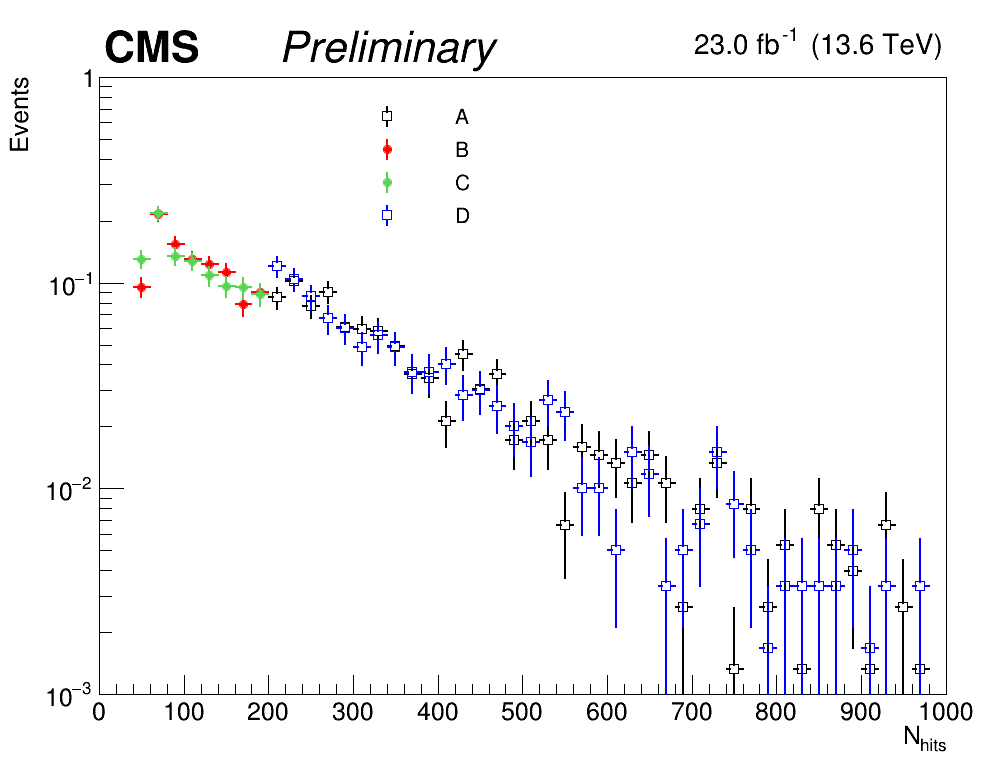

In [16]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
scale=True

#leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""

if category==1:
    for k in ['signal']:
        var = cscClusterSize[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        #tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        ma,mb,mc,md = return_abcd_masks(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        PHI_MIN,2.85,PHI_MAX,
                        tmp_cut
                        )
        
        bins = [50,1.8,3.2]
        tit = '|#Delta #varphi| (CSC,CSC)'
        plname="deltaPhi"
        cons = dphi
        
        bins = [50,0,1000]
        tit = 'N_{hits}'
        plname="n_hits"
        cons = var
        
        h0[k] = create_TH1D( cons[ma],title="",axis_title = [tit,'Events'], binning=bins)
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(25)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( cons[mb],title="",axis_title = [tit,'Events'], binning=bins)
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
            
        h2[k] = create_TH1D(cons[mc],title="",axis_title = [tit,'Events'], binning=bins)
        h2[k].SetLineColor(8)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(8)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral()) 
        
        h3[k] = create_TH1D(cons[md],title="",axis_title = [tit,'Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(25)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.1)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.001)
        h0[k].Draw('PE same')
        h1[k].Draw('PE same')
        h2[k].Draw('PE same')
        h3[k].Draw('PE same')
        leg.AddEntry(h0[k],"A","PE")
        leg.AddEntry(h1[k],"B","PE")
        leg.AddEntry(h2[k],"C","PE")
        leg.AddEntry(h3[k],"D","PE")


#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".pdf")
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".png") 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

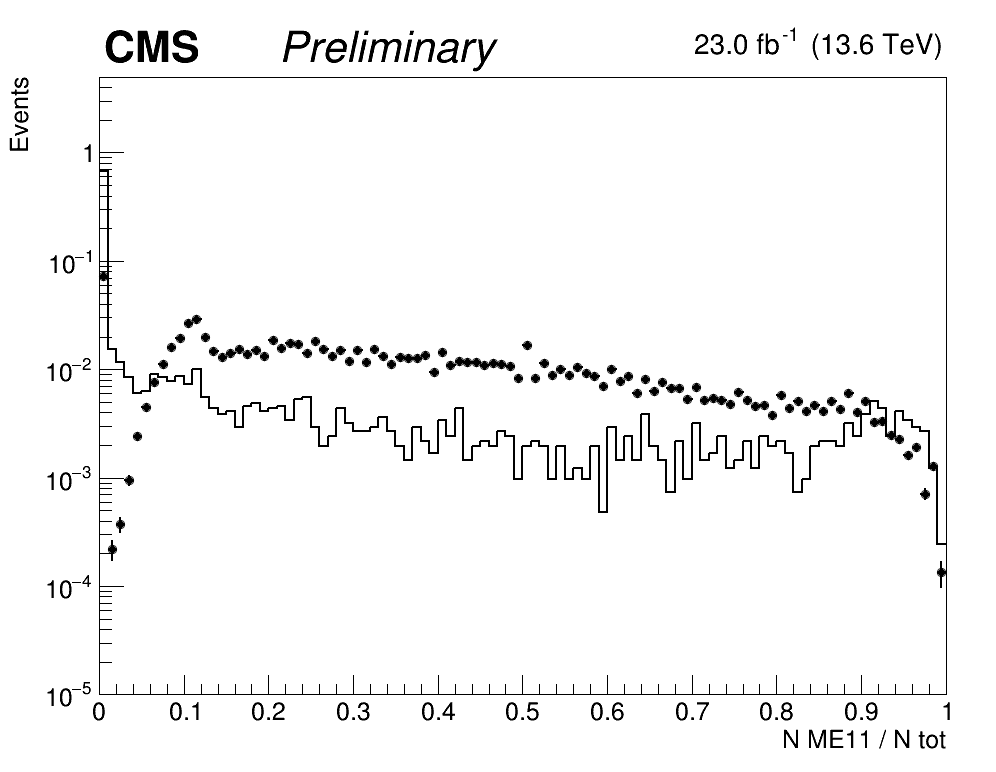

In [20]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
scale=True

#leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""

if category==1:
    for k in ['signal','data']:
        bins = [100,0,1]
        tit = "N ME11 / N tot"
        var = (cscClusterNRechitPlus11[k][:,1] + cscClusterNRechitMinus11[k][:,1])/cscClusterSize[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = sel_ev_post[k]#  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )

        if 'data' in k:
            tmp_cut = sel_ev_post[k] & (dphi<2.2)
        
        h0[k] = create_TH1D( var[tmp_cut],title="",axis_title = [tit,'Events'], binning=bins)
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

            
        if not scale:
            h0[k].SetMinimum(0.1)
            h0[k].SetMaximum(1.e6)
        else:
            h0[k].SetMaximum(5)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
        else:
            h0[k].Draw('HISTO same')
        #h1[k].Draw('PE same')
        #h2[k].Draw('PE same')
        #h3[k].Draw('PE same')
        #leg.AddEntry(h0[k],"A","PE")
        #leg.AddEntry(h1[k],"B","PE")
        #leg.AddEntry(h2[k],"C","PE")
        #leg.AddEntry(h3[k],"D","PE")


#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".pdf")
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".png") 

In [136]:
outDataCardsDir="/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6/"
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"
m=15
ct=1000
bkg_unc = [1.]
bkg_unc_name = ["syst"]
sig_unc = {}
sig_unc_name = []
signal_region = 'a'
prefix = 'csccsc_'

for phi_cut_scan in phi_cut_scan_list:
    outdir = outDataCardsDir+'phi_cut_scan/'
    if phi_cut_scan<=PHI_MIN:
        continue
    if not os.path.isdir(outdir): os.mkdir(outdir)
    make_datacard_2tag(
        outdir,
        modelName+"_"+str(phi_cut_scan).replace(".","p"),  
        signal_rate[phi_cut_scan], 
        normalization, 
        bkg_rate[phi_cut_scan], 
        observation[phi_cut_scan], 
        bkg_unc, 
        bkg_unc_name, 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
    )

In [102]:
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    print("\n")
    print("+++  ")
    print("+++  ", phi_cut_scan )
    print("+++  ")
    outdir = outDataCardsDir+'/phi_cut_scan/'
    text_file = open(outdir+modelName+"_"+str(phi_cut_scan).replace(".","p")+".txt", "r")
    for line in text_file:
        print(line.strip())
    text_file.close()
    print("\n")



+++  
+++   2.85
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	   6.20 	 182.00 	 539.00 	  18.37
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg
process 	 0	 1	 0	 1	 0	 1	 0	 1
rate	 2.972123e+02 	 1 	 2.887550e+02 	 1 	 2.319705e+02 	 1 	 2.235133e+02 	 1
------------------------------
csccsc_A   rateParam       chA     bkg      (@0*@2/@1)                    csccsc_B,csccsc_C,csccsc_D
csccsc_B   rateParam       chB     bkg     182.00        [0,1274.00]
csccsc_C   rateParam       chC     bkg     539.00        [0,3773.00]
csccsc_D   rateParam       chD     bkg     18.37        [0,128.62]
syst 	 lnN 	 - 	 - 	 - 	 - 	 - 	 - 	 - 	 2.0




## Submit combine with condor

In [103]:
combine_dir = "/afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/"
condor_dir = combine_dir + "condor_V1p19_v6/"
TOYS=False
blind = True
NCPUS   = 1
MEMORY  = 512
RUNTIME = 3600

if not os.path.isdir(condor_dir): os.mkdir(condor_dir)
else:
    print("Warning, directory exists, deleting old condor outputs ... ")
    os.system("ls " + condor_dir)
    os.system("rm " + condor_dir + "/*sh")
    os.system("rm " + condor_dir + "/*submit")
    os.system("rm " + condor_dir + "/*txt")

print("\n")
print("Condor stuff being stored in ", condor_dir)
print("\n")
original_location = os.popen("pwd").read()    

for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    outdir = outDataCardsDir+'/phi_cut_scan/'
    results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
    if not os.path.isdir(results): os.mkdir(results)
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")#+".txt"
    #print(card_name)
    #os.system('cat '+card_name)
    #print("\n")
    
    if TOYS:
        print("Toys - to be implemented")
    else:
        os.chdir(condor_dir)
        os.system("pwd")
        print("----->")
        print("Doing Asymptotic!!!!!!!!!")
        with open('job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh', 'w') as fout:
            fout.write("#!/bin/sh\n")
            fout.write("source /etc/profile.d/modules.sh\n")
            fout.write("module use -a /afs/desy.de/group/cms/modulefiles/\n")
            fout.write("module load cmssw\n")
            fout.write('cd '+combine_dir+' \n')
            fout.write("cmsenv\n")
            fout.write("echo Running on: " + outdir+card_name+".txt from directory: \n")
            fout.write("pwd \n")
            if blind:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + "  --run blind -m " + str(m) + " -n "+str(phi_cut_scan).replace(".","p")+" \n")
                #--SetParameters norm=1 --freezeParameters norm
            else:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + " -m " + str(m) + " -n " +str(phi_cut_scan).replace(".","p")+ " \n")
        os.system('chmod 755 job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh')

        with open('submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit', 'w') as fout:
            fout.write('executable   = ' + condor_dir + '/job_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.sh \n')
            fout.write('output       = ' + condor_dir + '/out_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('error        = ' + condor_dir + '/error_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('log          = ' + condor_dir + '/log_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write(' \n')
            fout.write('Requirements = OpSysAndVer == "CentOS7" \n')
            fout.write(' \n')
            fout.write('Request_Cpus = ' + str(NCPUS) + ' \n')
            fout.write('Request_Memory = ' + str(MEMORY) + ' \n')
            #fout.write('+RequestRuntime = ' + str(RUNTIME) + ' \n')                                                                                        
            fout.write('batch_name = m'+str(m)+'ct'+str(ct)+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'\n')
            fout.write('queue 1 \n')

        #submit condor                                                                                                                                      
        #os.system('condor_submit ' + 'submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit' + ' \n')
        os.system("sh job_m"+str(m)+"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".sh > "+condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt ")
        os.system("cat "+ condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt | grep -e Observed -e Expected | awk '{print $NF}' > " + results + "/" + card_name +".txt \n")
        print("Results saved in "+results + card_name +".txt")
        os.chdir(original_location[:-1])
                
#os.system("eval `scramv1 runtime -sh`")

Warning, directory exists, deleting old condor outputs ... 


Condor stuff being stored in  /afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/condor_V1p19_v6/


----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p85.txt
job_m15_ctau1000_n100.sh
job_m15_ctau1000_n110.sh
job_m15_ctau1000_n120.sh
job_m15_ctau1000_n130.sh
job_m15_ctau1000_n140.sh
job_m15_ctau1000_n150.sh
job_m15_ctau1000_n160.sh
job_m15_ctau1000_n170.sh
job_m15_ctau1000_n180.sh
job_m15_ctau1000_n190.sh
job_m15_ctau1000_n200.sh
job_m15_ctau1000_n210.sh
job_m15_ctau1000_n220.sh
job_m15_ctau1000_n230.sh
job_m15_ctau1000_n240.sh
job_m15_ctau1000_n250.sh
job_m15_ctau1000_n260.sh
job_m15_ctau1000_n270.sh
job_m15_ctau1000_n280.sh
job_m15_ctau1000_n290.sh
job_m15_ctau1000_n300.sh
job_m15_ctau1000_n310.sh
job_m15_ctau1000_n320.sh
job_

In [104]:
#!cat /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p2.txt

### Read and plot the limits

['0.0192', '0.0251', '0.0337', '0.0469', '0.0655']
Info: written plots/V1p19_v6/ABCD_limits_scan_dphi_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_limits_scan_dphi_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_limits_scan_dphi_cut_exactly_2_csc_clusters_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.png has been created


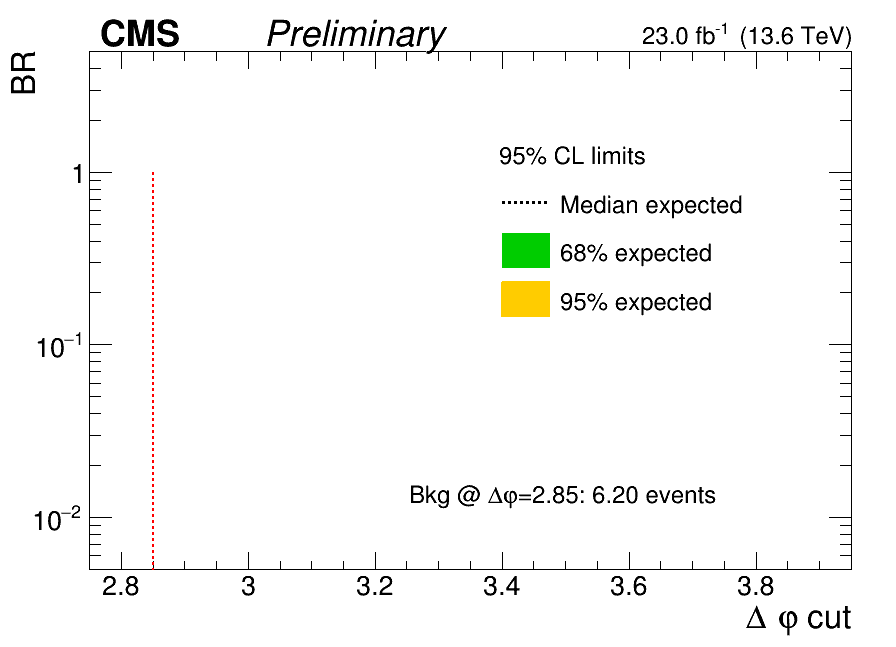

In [105]:
results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
exp = []
xval = []
obs = {}
mean_val = {}
sigma_2_up = {}
sigma_1_up = {}
sigma_1_down = {}
sigma_2_down = {}
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")
    
    if not os.path.isfile(results+card_name+".txt"):
        continue
    card = open( results+card_name+".txt", 'r')
    val = card.read().splitlines()
    if len(val) == 0:
        continue
    if len(val) != 6 and not blind:
        continue
    print(val)
    
    if blind:
        sigma_2_down[phi_cut_scan] = float(val[0])
        sigma_1_down[phi_cut_scan] = float(val[1])
        mean_val[phi_cut_scan]     = float(val[2])
        exp.append(float(val[2]))
        sigma_1_up[phi_cut_scan]   = float(val[3])
        sigma_2_up[phi_cut_scan]   = float(val[4])
    else:
        obs[phi_cut_scan]          = float(val[0])
        sigma_2_down[phi_cut_scan] = float(val[1])
        sigma_1_down[phi_cut_scan] = float(val[2])
        mean_val[phi_cut_scan]     = float(val[3])
        exp.append(float(val[3]))
        sigma_1_up[phi_cut_scan]   = float(val[4])
        sigma_2_up[phi_cut_scan]   = float(val[5])
        
Obs0s = rt.TGraph()
Exp0s = rt.TGraph()
Exp1s = rt.TGraphAsymmErrors()
Exp2s = rt.TGraphAsymmErrors()

n=0
for phi_cut_scan in phi_cut_scan_list:                                                                                                    
    if phi_cut_scan not in mean_val.keys():
        continue
    if not blind:
        Obs0s.SetPoint(n, phi_cut_scan, obs[phi_cut_scan])
    Exp0s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_1_down[phi_cut_scan], sigma_1_up[phi_cut_scan]-mean_val[phi_cut_scan])
    Exp2s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp2s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_2_down[phi_cut_scan], sigma_2_up[phi_cut_scan]-mean_val[phi_cut_scan])
    n+=1
    
Exp2s.SetLineWidth(2)
Exp2s.SetLineStyle(1)
Exp0s.SetLineStyle(2)
Exp0s.SetLineWidth(3)                                                                                                                            
Obs0s.SetLineStyle(1)
Obs0s.SetLineWidth(3)                                                                                                                          
Exp1s.SetFillColor(417)
Exp1s.SetLineColor(417)
Exp2s.SetFillColor(800)
Exp2s.SetLineColor(800)
Exp2s.GetXaxis().SetTitle("#Delta #varphi cut")
Exp2s.GetYaxis().SetTitle("BR")
Exp2s.GetXaxis().SetNoExponent(True)
Exp2s.GetXaxis().SetMoreLogLabels(True)
Exp2s.GetXaxis().SetTitleSize(0.048)
Exp2s.GetYaxis().SetTitleSize(0.048)                                                                                                                                           
Exp2s.GetXaxis().SetTitleOffset(0.9)
Exp2s.GetYaxis().SetTitleOffset(0.85)

leg = rt.TLegend(0.55, 0.525-0.025, 0.9-0.05, 0.825-0.025)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)
c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s,  "Median expected", "l")
leg.AddEntry(Exp1s, "68% expected", "f")
leg.AddEntry(Exp2s, "95% expected", "f")
if not blind:
    leg.AddEntry(Obs0s, "Observed", "l")
Exp2s.GetXaxis().SetTitleSize(0.055)
Exp2s.GetYaxis().SetTitleSize(0.055)
Exp2s.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp2s.GetYaxis().SetLabelSize(0.045)

for mv in mean_val.keys():
    xval.append(mv)
    exp.append(mean_val[mv])

best_phi = rt.TLine(xval[ np.argmin(exp) ],0.005,xval[ np.argmin(exp) ],1)
best_phi.SetLineColor(2)
best_phi.SetLineStyle(2)
best_phi.SetLineWidth(2)


Exp2s.SetMinimum(0.005)
Exp2s.SetMaximum(5)
Exp2s.Draw("A3")
Exp1s.Draw("SAME, 3")
Exp0s.Draw("SAME, L")
if not blind:
    Obs0s.Draw("SAME, L")
best_phi.Draw("SAME, L")
leg.Draw()

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.8,0.25, ("Bkg @ #Delta#varphi=%s: %.2f events" % ( str(xval[ np.argmin(exp) ]),bkg_rate[ xval[ np.argmin(exp) ] ] [0])))

c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".png")
#Store graphs for future comparisons
newFile = rt.TFile("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root", "RECREATE")
newFile.cd()
Exp0s.Write("exp")
Exp1s.Write("1sigma")
Exp2s.Write("2sigma")
c1.Write()
newFile.Close()
print("Info: written "+"plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root")

In [106]:
print(np.argmin(exp))
print(exp)
print(exp[ np.argmin(exp) ])
print(xval[ np.argmin(exp) ])
print(xval)

0
[0.0337, 0.0337]
0.0337
2.85
[2.85]


### Comparing limits

No jet veto, no muon veto, no time spread cut

In [23]:
xval = [1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.90, 2.95, 3.0, 3.05, 3.1]
exp_1 = [0.2295, 0.1733, 0.1372, 0.1465, 0.1323, 0.1196, 0.1216, 0.1079, 0.104, 0.1021, 0.0972, 0.0938, 0.0884, 0.084, 0.0815, 0.0786, 0.0767, 0.0718, 0.0708, 0.0688, 0.0659, 0.0708, 0.0737, 0.0825, 0.0986, 0.1357, 0.2295, 0.1733, 0.1372, 0.1465, 0.1323, 0.1196, 0.1216, 0.1079, 0.104, 0.1021, 0.0972, 0.0938, 0.0884, 0.084, 0.0815, 0.0786, 0.0767, 0.0718, 0.0708, 0.0688, 0.0659, 0.0708, 0.0737, 0.0825, 0.0986, 0.1357]

No jet veto, no muon veto, yes time spread cut on 2nd cluster

In [24]:
exp_2 = [0.2119, 0.1602, 0.1147, 0.106, 0.0991, 0.0894, 0.0894, 0.0737, 0.0708, 0.0713, 0.0669, 0.0649, 0.061, 0.0591, 0.0571, 0.0532, 0.0532, 0.0513, 0.0513, 0.0503, 0.0503, 0.0547, 0.0576, 0.0674, 0.0825, 0.1045, 0.2119, 0.1602, 0.1147, 0.106, 0.0991, 0.0894, 0.0894, 0.0737, 0.0708, 0.0713, 0.0669, 0.0649, 0.061, 0.0591, 0.0571, 0.0532, 0.0532, 0.0513, 0.0513, 0.0503, 0.0503, 0.0547, 0.0576, 0.0674, 0.0825, 0.1045]

Yes jet veto, no muon veto, yes time spread cut on 2nd cluster

In [25]:
exp_3 = [0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105, 0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105]

Yes jet veto, yes muon veto, yes time spread cut on 2nd cluster

In [26]:
exp_4 = [0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105, 0.2197, 0.1626, 0.1157, 0.106, 0.0981, 0.0894, 0.0894, 0.0737, 0.0708, 0.0708, 0.0669, 0.064, 0.061, 0.0591, 0.0562, 0.0522, 0.0522, 0.0503, 0.0503, 0.0498, 0.0493, 0.0542, 0.0571, 0.0669, 0.0811, 0.105]

None
x[0]=1.85, y[0]=0.2295
x[1]=1.9, y[1]=0.1733
x[2]=1.95, y[2]=0.1372
x[3]=2, y[3]=0.1465
x[4]=2.05, y[4]=0.1323
x[5]=2.1, y[5]=0.1196
x[6]=2.15, y[6]=0.1216
x[7]=2.2, y[7]=0.1079
x[8]=2.25, y[8]=0.104
x[9]=2.3, y[9]=0.1021
x[10]=2.35, y[10]=0.0972
x[11]=2.4, y[11]=0.0938
x[12]=2.45, y[12]=0.0884
x[13]=2.5, y[13]=0.084
x[14]=2.55, y[14]=0.0815
x[15]=2.6, y[15]=0.0786
x[16]=2.65, y[16]=0.0767
x[17]=2.7, y[17]=0.0718
x[18]=2.75, y[18]=0.0708
x[19]=2.8, y[19]=0.0688
x[20]=2.85, y[20]=0.0659
x[21]=2.9, y[21]=0.0708
x[22]=2.95, y[22]=0.0737
x[23]=3, y[23]=0.0825
x[24]=3.05, y[24]=0.0986
x[25]=3.1, y[25]=0.1357


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_limits_compare_vetoes_scan_dphi_cut_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_limits_compare_vetoes_scan_dphi_cut_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.png has been created


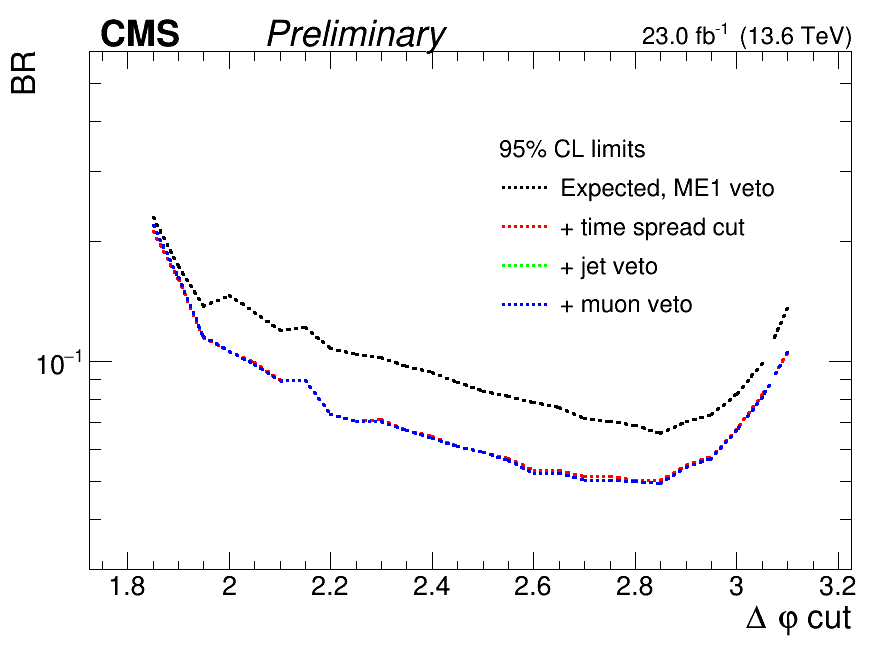

In [27]:
Exp0s_1 = rt.TGraph(len(xval),np.array(xval),np.array(exp_1))
Exp0s_2 = rt.TGraph(len(xval),np.array(xval),np.array(exp_2))
Exp0s_3 = rt.TGraph(len(xval),np.array(xval),np.array(exp_3))
Exp0s_4 = rt.TGraph(len(xval),np.array(xval),np.array(exp_4))
Exp0s_1.SetTitle("")

Exp0s_1.SetLineWidth(3)
Exp0s_1.SetLineStyle(2)
Exp0s_1.SetLineColor(1)

Exp0s_2.SetLineWidth(3)
Exp0s_2.SetLineStyle(2)
Exp0s_2.SetLineColor(2)

Exp0s_3.SetLineWidth(3)
Exp0s_3.SetLineStyle(2)
Exp0s_3.SetLineColor(3)

Exp0s_4.SetLineWidth(3)
Exp0s_4.SetLineStyle(2)
Exp0s_4.SetLineColor(4)

Exp0s_1.GetXaxis().SetTitle("#Delta #varphi cut")
Exp0s_1.GetYaxis().SetTitle("BR")
Exp0s_1.GetXaxis().SetNoExponent(True)
Exp0s_1.GetXaxis().SetMoreLogLabels(True)
Exp0s_1.GetXaxis().SetTitleSize(0.055)
Exp0s_1.GetYaxis().SetTitleSize(0.055)             
Exp0s_1.GetXaxis().SetTitleOffset(0.9)
Exp0s_1.GetYaxis().SetTitleOffset(0.85)
Exp0s_1.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp0s_1.GetYaxis().SetLabelSize(0.045)

print(Exp0s_1.Print())

leg = rt.TLegend(0.55, 0.525-0.025, 0.9-0.05, 0.825-0.025)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)

c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s_1,  "Expected, ME1 veto", "l")
leg.AddEntry(Exp0s_2,  "+ time spread cut", "l")
leg.AddEntry(Exp0s_3,  "+ jet veto", "l")
leg.AddEntry(Exp0s_4,  "+ muon veto", "l")


Exp0s_1.SetMinimum(0.03)
Exp0s_1.SetMaximum(0.6)
Exp0s_1.Draw("AL")
Exp0s_2.Draw("L sames")
Exp0s_3.Draw("L sames")
Exp0s_4.Draw("L sames")
leg.Draw()
c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_compare_vetoes_scan_dphi_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_compare_vetoes_scan_dphi_cut"+plot_string_plus+".png")

## N hits scan

In [28]:
PHI_CUT_SEL = 2.85
print(np.linspace(100,600,50+1).astype(int))

[100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450
 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600]


In [29]:
n_cut_scan_list = np.array([100,200,300,400])#np.linspace(1.5,3.1,32+1)
n_cut_scan_list = np.linspace(100,600,50+1).astype(int)

#LESS
n_cut_scan_list = np.array([200,300,400,1000])

time_cut_string = "IT"
plot_string_plus = plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = "|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for n_cut_scan in n_cut_scan_list:
    signal_rate[n_cut_scan] = {}

#print('k\t n\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==1:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        var = cscClusterSize[k][:,1]
        t_var = cscClusterTime[k][:,1]
        t_spread_var = cscClusterTimeSpread[k][:,1]
        dphi = np.abs(dPhi_csc_csc[k])
        tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        for n_cut_scan in n_cut_scan_list:
            if n_cut_scan<=N_MIN: continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,n_cut_scan,N_MAX,
                    PHI_MIN,PHI_CUT_SEL,PHI_MAX,
                    tmp_cut,
                    do_b_extrapolation=True
                    )
                print('k\t n\t B\t C\t D\t A\t pred\t\t zval\t perc')
                print("%s\t %i\t %.2f\t %i\t %.2f\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,n_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                print("\n")
                observation[n_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[n_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,n_cut_scan,N_MAX,
                    PHI_MIN,PHI_CUT_SEL,PHI_MAX,
                    tmp_cut
                    )
                a[k] = (np.sum(weight[k][ ma ]))*lumi
                b[k] = (np.sum(weight[k][ mb ]))*lumi
                c[k] = (np.sum(weight[k][ mc ]))*lumi
                d[k] = (np.sum(weight[k][ md ]))*lumi
                print("%s\t %i\t %.2f\t %.2f\t %.2f\t %.2f\t "%(k,n_cut_scan,b[k],c[k],d[k],a[k]))
                signal_rate[n_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



d	 d low	 d pred
143	 52	  136.50
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 100	 179.00	 569	 136.50	 39	 42.94 +- 3.21	 0.60	 10.11


d	 d low	 d pred
120	 43	  112.87
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 110	 189.00	 592	 112.87	 29	 36.04 +- 2.62	 1.17	 24.26


d	 d low	 d pred
99	 35	  91.87
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 120	 190.00	 613	 91.87	 28	 28.48 +- 2.07	 0.14	 1.70


d	 d low	 d pred
83	 31	  81.37
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 130	 191.00	 629	 81.37	 27	 24.71 +- 1.79	 -0.38	 -8.48


d	 d low	 d pred
76	 29	  76.12
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 140	 193.00	 636	 76.12	 25	 23.10 +- 1.66	 -0.31	 -7.60


d	 d low	 d pred
69	 27	  70.87


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


b	 b pred
196	196.00
k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 150	 196.00	 643	 70.87	 22	 21.60 +- 1.54	 -0.02	 -1.80


d	 d low	 d pred
57	 23	  60.37
b	 b pred
197	201.41


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 160	 201.41	 655	 60.37	 21	 18.56 +- 1.31	 -0.46	 -11.60


d	 d low	 d pred
52	 19	  49.87
b	 b pred
202	203.46


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 170	 203.46	 660	 49.87	 16	 15.38 +- 1.08	 -0.08	 -3.90


d	 d low	 d pred
50	 18	  47.25
b	 b pred
202	204.64


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 180	 204.64	 662	 47.25	 16	 14.61 +- 1.02	 -0.28	 -8.71


d	 d low	 d pred
46	 16	  42.00
b	 b pred
203	205.31


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 190	 205.31	 666	 42.00	 15	 12.95 +- 0.90	 -0.46	 -13.68


d	 d low	 d pred
44	 15	  39.37
b	 b pred
205	208.32


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 200	 208.32	 668	 39.37	 13	 12.28 +- 0.85	 -0.11	 -5.54


d	 d low	 d pred
34	 13	  34.12
b	 b pred
210	209.88


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 210	 209.88	 678	 34.12	 8	 10.56 +- 0.73	 0.91	 32.04


d	 d low	 d pred
32	 13	  34.12
b	 b pred
212	209.62


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 220	 209.62	 680	 34.12	 6	 10.52 +- 0.73	 1.61	 75.32


d	 d low	 d pred
28	 10	  26.25
b	 b pred
213	211.70


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 230	 211.70	 684	 26.25	 5	 8.12 +- 0.56	 1.30	 62.49


d	 d low	 d pred
26	 8	  21.00
b	 b pred
213	212.72


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 240	 212.72	 686	 21.00	 5	 6.51 +- 0.45	 0.75	 30.24


d	 d low	 d pred
25	 8	  21.00
b	 b pred
213	211.81


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 250	 211.81	 687	 21.00	 5	 6.47 +- 0.44	 0.74	 29.49


d	 d low	 d pred
25	 8	  21.00
b	 b pred
213	211.99


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 260	 211.99	 687	 21.00	 5	 6.48 +- 0.45	 0.74	 29.60


d	 d low	 d pred
25	 8	  21.00
b	 b pred
214	214.60


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 270	 214.60	 687	 21.00	 4	 6.56 +- 0.45	 1.22	 64.00


d	 d low	 d pred
24	 7	  18.37
b	 b pred
214	213.49


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 280	 213.49	 688	 18.37	 4	 5.70 +- 0.39	 0.90	 42.55


d	 d low	 d pred
23	 7	  18.37
b	 b pred
214	214.96


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 290	 214.96	 689	 18.37	 4	 5.73 +- 0.39	 0.91	 43.32


d	 d low	 d pred
23	 7	  18.37
b	 b pred
214	214.16


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 300	 214.16	 689	 18.37	 4	 5.71 +- 0.39	 0.90	 42.79


d	 d low	 d pred
20	 7	  18.37
b	 b pred
214	213.99


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 310	 213.99	 692	 18.37	 4	 5.68 +- 0.39	 0.89	 42.05


d	 d low	 d pred
17	 6	  15.75
b	 b pred
214	217.27


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 320	 217.27	 695	 15.75	 4	 4.92 +- 0.33	 0.58	 23.09


d	 d low	 d pred
16	 5	  13.12
b	 b pred
214	217.53


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 330	 217.53	 696	 13.12	 4	 4.10 +- 0.28	 0.21	 2.55


d	 d low	 d pred
16	 5	  13.12
b	 b pred
216	215.78


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 340	 215.78	 696	 13.12	 2	 4.07 +- 0.28	 1.35	 103.45


d	 d low	 d pred
16	 5	  13.12
b	 b pred
216	216.01


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 350	 216.01	 696	 13.12	 2	 4.07 +- 0.28	 1.35	 103.68


d	 d low	 d pred
15	 5	  13.12
b	 b pred
216	221.73


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 360	 221.73	 697	 13.12	 2	 4.18 +- 0.28	 1.39	 108.77


d	 d low	 d pred
13	 4	  10.50
b	 b pred
216	225.69


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 370	 225.69	 699	 10.50	 2	 3.39 +- 0.23	 1.04	 69.51


d	 d low	 d pred
13	 4	  10.50
b	 b pred
216	229.17


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 380	 229.17	 699	 10.50	 2	 3.44 +- 0.23	 1.06	 72.12


d	 d low	 d pred
11	 4	  10.50
b	 b pred
216	221.15


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 390	 221.15	 701	 10.50	 2	 3.31 +- 0.22	 1.00	 65.62


d	 d low	 d pred
11	 4	  10.50
b	 b pred
216	223.17


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 400	 223.17	 701	 10.50	 2	 3.34 +- 0.22	 1.01	 67.14


d	 d low	 d pred
10	 4	  10.50
b	 b pred
216	224.25


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 410	 224.25	 702	 10.50	 2	 3.35 +- 0.22	 1.02	 67.71


d	 d low	 d pred
9	 4	  10.50
b	 b pred
216	223.48


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 420	 223.48	 703	 10.50	 2	 3.34 +- 0.22	 1.01	 66.89


d	 d low	 d pred
8	 3	  7.87
b	 b pred
216	222.88


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 430	 222.88	 704	 7.87	 2	 2.49 +- 0.17	 0.55	 24.66


d	 d low	 d pred
7	 2	  5.25
b	 b pred
216	226.50


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 440	 226.50	 705	 5.25	 2	 1.69 +- 0.11	 0.01	 -15.66


d	 d low	 d pred
7	 2	  5.25
b	 b pred
216	221.22


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 450	 221.22	 705	 5.25	 2	 1.65 +- 0.11	 -0.03	 -17.63


d	 d low	 d pred
7	 2	  5.25
b	 b pred
216	227.02


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 460	 227.02	 705	 5.25	 2	 1.69 +- 0.11	 0.01	 -15.47


d	 d low	 d pred
6	 2	  5.25
b	 b pred
216	225.14


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 470	 225.14	 706	 5.25	 2	 1.67 +- 0.11	 -0.01	 -16.29


d	 d low	 d pred
6	 2	  5.25
b	 b pred
216	231.77


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 480	 231.77	 706	 5.25	 2	 1.72 +- 0.11	 0.03	 -13.83


d	 d low	 d pred
6	 2	  5.25
b	 b pred
216	232.52


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 490	 232.52	 706	 5.25	 2	 1.73 +- 0.11	 0.03	 -13.55


d	 d low	 d pred
6	 2	  5.25
b	 b pred
216	234.64


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 500	 234.64	 706	 5.25	 2	 1.74 +- 0.11	 0.05	 -12.76


d	 d low	 d pred
6	 2	  5.25
b	 b pred
216	232.90


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 510	 232.90	 706	 5.25	 2	 1.73 +- 0.11	 0.04	 -13.40


d	 d low	 d pred
5	 2	  5.25
b	 b pred
216	242.85


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 520	 242.85	 707	 5.25	 2	 1.80 +- 0.12	 0.09	 -9.83


d	 d low	 d pred
5	 2	  5.25
b	 b pred
216	247.75


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 530	 247.75	 707	 5.25	 2	 1.84 +- 0.12	 0.12	 -8.01


d	 d low	 d pred
5	 2	  5.25
b	 b pred
216	240.84


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 540	 240.84	 707	 5.25	 2	 1.79 +- 0.12	 0.08	 -10.58


d	 d low	 d pred
5	 2	  5.25
b	 b pred
216	234.68


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 550	 234.68	 707	 5.25	 2	 1.74 +- 0.11	 0.05	 -12.87


d	 d low	 d pred
5	 2	  5.25
b	 b pred
216	230.96


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 560	 230.96	 707	 5.25	 2	 1.72 +- 0.11	 0.03	 -14.25


d	 d low	 d pred
5	 2	  5.25
b	 b pred
216	231.73


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 570	 231.73	 707	 5.25	 2	 1.72 +- 0.11	 0.03	 -13.96


d	 d low	 d pred
4	 2	  5.25
b	 b pred
217	238.53


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 580	 238.53	 708	 5.25	 1	 1.77 +- 0.11	 0.95	 76.88


d	 d low	 d pred
4	 2	  5.25
b	 b pred
217	239.17


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 590	 239.17	 708	 5.25	 1	 1.77 +- 0.11	 0.95	 77.35


d	 d low	 d pred
4	 2	  5.25
b	 b pred
217	245.40


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)


k	 n	 B	 C	 D	 A	 pred		 zval	 perc
data	 600	 245.40	 708	 5.25	 1	 1.82 +- 0.12	 0.98	 81.97


signal	 100	 123.23	 97.86	 372.12	 477.84	 
signal	 110	 141.36	 110.55	 359.43	 459.71	 
signal	 120	 158.27	 131.09	 338.89	 442.80	 
signal	 130	 177.00	 146.19	 323.79	 424.07	 
signal	 140	 201.77	 158.27	 311.71	 399.30	 
signal	 150	 215.66	 172.17	 297.82	 385.41	 
signal	 160	 239.22	 184.85	 285.13	 361.85	 
signal	 170	 254.32	 200.56	 269.42	 346.75	 
signal	 180	 267.61	 215.66	 254.32	 333.46	 
signal	 190	 282.71	 225.93	 244.05	 318.36	 
signal	 200	 297.82	 238.62	 231.37	 303.25	 
signal	 210	 306.88	 251.91	 218.08	 294.19	 
signal	 220	 321.38	 267.61	 202.37	 279.69	 
signal	 230	 335.87	 278.49	 191.50	 265.20	 
signal	 240	 347.96	 292.38	 177.60	 253.11	 
signal	 250	 362.45	 303.86	 166.12	 238.62	 
signal	 260	 372.12	 310.50	 159.48	 228.95	 
signal	 270	 386.62	 317.15	 152.83	 214.45	 
signal	 280	 401.72	 326.21	 143.77	 199.35	 
signal	 290	 411.39	 331.65	 1

In [30]:
outDataCardsDir="/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6/"
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"
m=15
ct=1000
bkg_unc = [1.]
bkg_unc_name = ["syst"]
sig_unc = {}
sig_unc_name = []
signal_region = 'a'
prefix = 'csccsc_'

for n_cut_scan in n_cut_scan_list:
    outdir = outDataCardsDir+'n_cut_scan/'
    if n_cut_scan<=N_MIN:
        continue
    if not os.path.isdir(outdir): os.mkdir(outdir)
    make_datacard_2tag(
        outdir,
        modelName+"_"+str(int(n_cut_scan)),  
        signal_rate[n_cut_scan], 
        normalization, 
        bkg_rate[n_cut_scan], 
        observation[n_cut_scan], 
        bkg_unc, 
        bkg_unc_name, 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
    )

In [31]:
for n_cut_scan in n_cut_scan_list:
    if n_cut_scan<=N_MIN:continue
    print("\n")
    print("+++  ")
    print("+++  ", n_cut_scan )
    print("+++  ")
    outdir = outDataCardsDir+'/n_cut_scan/'
    text_file = open(outdir+modelName+"_"+str(int(n_cut_scan))+".txt", "r")
    for line in text_file:
        print(line.strip())
    text_file.close()
    print("\n")



+++  
+++   100
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	  42.94 	 179.00 	 569.00 	 136.50
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg 	 ggH	 bkg
process 	 0	 1	 0	 1	 0	 1	 0	 1
rate	 4.778351e+02 	 1 	 1.232343e+02 	 1 	 9.786257e+01 	 1 	 3.721194e+02 	 1
------------------------------
csccsc_A   rateParam       chA     bkg      (@0*@2/@1)                    csccsc_B,csccsc_C,csccsc_D
csccsc_B   rateParam       chB     bkg     179.00        [0,1253.00]
csccsc_C   rateParam       chC     bkg     569.00        [0,3983.00]
csccsc_D   rateParam       chD     bkg     136.50        [0,955.50]
syst 	 lnN 	 - 	 - 	 - 	 - 	 - 	 - 	 - 	 2.0




+++  
+++   110
+++  
# signal norm 1
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	  36.04 	 189.00 	 592.00 	 112.

## Submit combine

In [32]:
combine_dir = "/afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/"
condor_dir = combine_dir + "condor_V1p19_v6/"
TOYS=False
blind = True
NCPUS   = 1
MEMORY  = 512
RUNTIME = 3600

if not os.path.isdir(condor_dir): os.mkdir(condor_dir)
else:
    print("Warning, directory exists, deleting old condor outputs ... ")
    os.system("ls " + condor_dir)
    os.system("rm " + condor_dir + "/*sh")
    os.system("rm " + condor_dir + "/*submit")
    os.system("rm " + condor_dir + "/*txt")

print("\n")
print("Condor stuff being stored in ", condor_dir)
print("\n")
original_location = os.popen("pwd").read()    

for n_cut_scan in n_cut_scan_list:
    if n_cut_scan<=N_MIN:continue
    outdir = outDataCardsDir+'/n_cut_scan/'
    results = outDataCardsDir+'/n_cut_scan/'+'combine_results/'
    if not os.path.isdir(results): os.mkdir(results)
    card_name = modelName+"_"+str(int(n_cut_scan))
    
    label = '_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))
    
    if TOYS:
        print("Toys - to be implemented")
    else:
        os.chdir(condor_dir)
        os.system("pwd")
        print("----->")
        print("Doing Asymptotic!!!!!!!!!")
        with open('job_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+'.sh', 'w') as fout:
            fout.write("#!/bin/sh\n")
            fout.write("source /etc/profile.d/modules.sh\n")
            fout.write("module use -a /afs/desy.de/group/cms/modulefiles/\n")
            fout.write("module load cmssw\n")
            fout.write('cd '+combine_dir+' \n')
            fout.write("cmsenv\n")
            fout.write("echo Running on: " + outdir+card_name+".txt from directory: \n")
            fout.write("pwd \n")
            if blind:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + "  --run blind -m " + str(m) + " -n "+str(int(n_cut_scan))+" \n")
                #--SetParameters norm=1 --freezeParameters norm
            else:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + " -m " + str(m) + " -n " +str(int(n_cut_scan))+ " \n")
        os.system('chmod 755 job_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+'.sh')

        with open('submit_m'+str(m)+'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+'.submit', 'w') as fout:
            fout.write('executable   = ' + condor_dir + '/job_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.sh \n')
            fout.write('output       = ' + condor_dir + '/out_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.txt \n')
            fout.write('error        = ' + condor_dir + '/error_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.txt \n')
            fout.write('log          = ' + condor_dir + '/log_m'+ str(m) +'_ctau'+str(ct)+'_n'+str(int(n_cut_scan))+ '.txt \n')
            fout.write(' \n')
            fout.write('Requirements = OpSysAndVer == "CentOS7" \n')
            fout.write(' \n')
            fout.write('Request_Cpus = ' + str(NCPUS) + ' \n')
            fout.write('Request_Memory = ' + str(MEMORY) + ' \n')
            #fout.write('+RequestRuntime = ' + str(RUNTIME) + ' \n')                                                                                        
            fout.write('batch_name = m'+str(m)+'ct'+str(ct)+str(ct)+'_n'+str(int(n_cut_scan))+'\n')
            fout.write('queue 1 \n')

        #submit condor                                                                                                                                      
        #os.system('condor_submit ' + 'submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit' + ' \n')
        os.system("sh job_m"+str(m)+"_ctau"+str(ct)+"_n"+str(int(n_cut_scan))+".sh > "+condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_n"+str(int(n_cut_scan))+".txt ")
        os.system("cat "+ condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_n"+str(int(n_cut_scan))+".txt | grep -e Observed -e Expected | awk '{print $NF}' > " + results + "/" + card_name +".txt \n")
        print("Results saved in "+results + card_name +".txt")
        os.chdir(original_location[:-1])
                
#os.system("eval `scramv1 runtime -sh`")

Warning, directory exists, deleting old condor outputs ... 


Condor stuff being stored in  /afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/condor_V1p19_v6/


----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_100.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_110.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_120.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/co

Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_480.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_490.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_500.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_510.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//n_cut_scan/combine_results/ggH_HToSS

## Plot limits

['0.0594', '0.0704', '0.0854', '0.1042', '0.1242']
['0.0524', '0.0626', '0.0767', '0.0941', '0.1142']
['0.0436', '0.0526', '0.0649', '0.0812', '0.0999']
['0.0399', '0.0484', '0.0601', '0.0759', '0.0946']
['0.0405', '0.0492', '0.0610', '0.0771', '0.0962']
['0.0394', '0.0481', '0.0601', '0.0759', '0.0955']
['0.0370', '0.0455', '0.0571', '0.0731', '0.0923']
['0.0328', '0.0406', '0.0513', '0.0672', '0.0863']
['0.0324', '0.0404', '0.0513', '0.0672', '0.0870']
['0.0312', '0.0386', '0.0493', '0.0654', '0.0849']
['0.0310', '0.0389', '0.0503', '0.0667', '0.0866']
['0.0286', '0.0356', '0.0464', '0.0623', '0.0823']
['0.0298', '0.0371', '0.0483', '0.0649', '0.0858']
['0.0255', '0.0325', '0.0435', '0.0590', '0.0799']
['0.0226', '0.0292', '0.0396', '0.0550', '0.0757']
['0.0240', '0.0308', '0.0415', '0.0577', '0.0799']
['0.0251', '0.0323', '0.0435', '0.0604', '0.0831']
['0.0274', '0.0349', '0.0474', '0.0655', '0.0897']
['0.0265', '0.0342', '0.0464', '0.0660', '0.0915']
['0.0281', '0.0364', '0.0493', 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6/ABCD_limits_scan_n_cut_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6/ABCD_limits_scan_n_cut_exactly_2_csc_clusters_ME_veto_time_spread_cut_jet_muon_veto_2nd_IT_dR0p5.png has been created


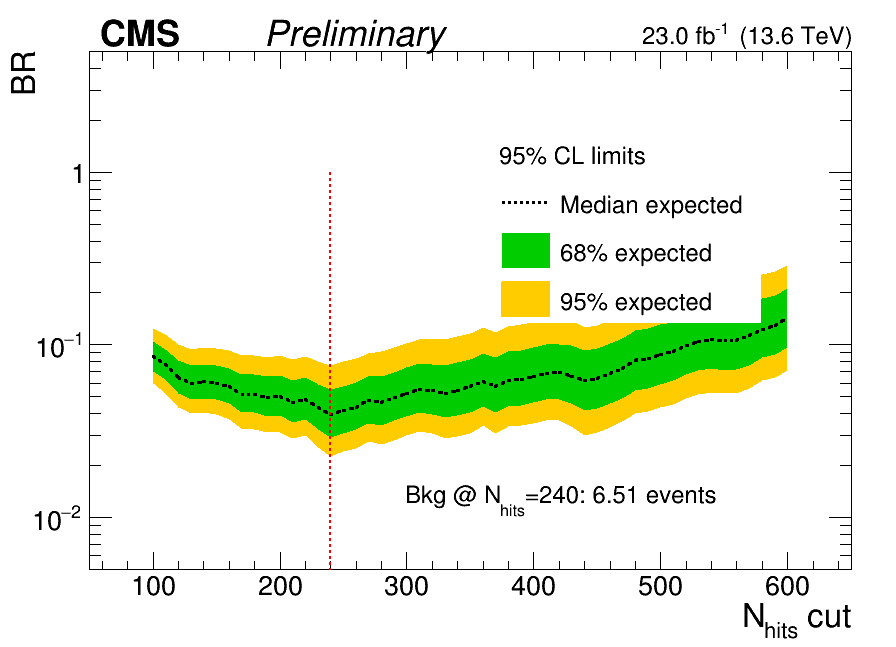

In [33]:
results = outDataCardsDir+'/n_cut_scan/'+'combine_results/'
exp = []
xval = []
obs = {}
mean_val = {}
sigma_2_up = {}
sigma_1_up = {}
sigma_1_down = {}
sigma_2_down = {}
for n_cut_scan in n_cut_scan_list:
    if n_cut_scan<=N_MIN:continue
    card_name = modelName+"_"+str(int(n_cut_scan))
    
    if not os.path.isfile(results+card_name+".txt"):
        continue
    card = open( results+card_name+".txt", 'r')
    val = card.read().splitlines()
    if len(val) == 0:
        continue
    if len(val) != 6 and not blind:
        continue
    print(val)
    
    if blind:
        sigma_2_down[n_cut_scan] = float(val[0])
        sigma_1_down[n_cut_scan] = float(val[1])
        mean_val[n_cut_scan]     = float(val[2])
        sigma_1_up[n_cut_scan]   = float(val[3])
        sigma_2_up[n_cut_scan]   = float(val[4])
    else:
        obs[n_cut_scan]          = float(val[0])
        sigma_2_down[n_cut_scan] = float(val[1])
        sigma_1_down[n_cut_scan] = float(val[2])
        mean_val[n_cut_scan]     = float(val[3])
        sigma_1_up[n_cut_scan]   = float(val[4])
        sigma_2_up[n_cut_scan]   = float(val[5])
        
Obs0s = rt.TGraph()
Exp0s = rt.TGraph()
Exp1s = rt.TGraphAsymmErrors()
Exp2s = rt.TGraphAsymmErrors()

n=0
for n_cut_scan in n_cut_scan_list:                                                                                                    
    if n_cut_scan not in mean_val.keys():
        continue
    if not blind:
        Obs0s.SetPoint(n, n_cut_scan, obs[n_cut_scan])
    Exp0s.SetPoint(n, n_cut_scan, mean_val[n_cut_scan])
    Exp1s.SetPoint(n, n_cut_scan, mean_val[n_cut_scan])
    Exp1s.SetPointError(n, 0., 0., mean_val[n_cut_scan]-sigma_1_down[n_cut_scan], sigma_1_up[n_cut_scan]-mean_val[n_cut_scan])
    Exp2s.SetPoint(n, n_cut_scan, mean_val[n_cut_scan])
    Exp2s.SetPointError(n, 0., 0., mean_val[n_cut_scan]-sigma_2_down[n_cut_scan], sigma_2_up[n_cut_scan]-mean_val[n_cut_scan])
    n+=1
    
Exp2s.SetLineWidth(2)
Exp2s.SetLineStyle(1)
Exp0s.SetLineStyle(2)
Exp0s.SetLineWidth(3)                                                                                                                            
Obs0s.SetLineStyle(1)
Obs0s.SetLineWidth(3)                                                                                                                          
Exp1s.SetFillColor(417)
Exp1s.SetLineColor(417)
Exp2s.SetFillColor(800)
Exp2s.SetLineColor(800)
Exp2s.GetXaxis().SetTitle("N_{hits} cut")
Exp2s.GetYaxis().SetTitle("BR")
Exp2s.GetXaxis().SetNoExponent(True)
Exp2s.GetXaxis().SetMoreLogLabels(True)
Exp2s.GetXaxis().SetTitleSize(0.048)
Exp2s.GetYaxis().SetTitleSize(0.048)                                                                                                                                           
Exp2s.GetXaxis().SetTitleOffset(0.9)
Exp2s.GetYaxis().SetTitleOffset(0.85)

leg = rt.TLegend(0.55, 0.525-0.025, 0.9-0.05, 0.825-0.025)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)
c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s,  "Median expected", "l")
leg.AddEntry(Exp1s, "68% expected", "f")
leg.AddEntry(Exp2s, "95% expected", "f")
if not blind:
    leg.AddEntry(Obs0s, "Observed", "l")
Exp2s.GetXaxis().SetTitleSize(0.055)
Exp2s.GetYaxis().SetTitleSize(0.055)
Exp2s.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp2s.GetYaxis().SetLabelSize(0.045)

for mv in mean_val.keys():
    xval.append(mv)
    exp.append(mean_val[mv])

best_phi = rt.TLine(xval[ np.argmin(exp) ],0.005,xval[ np.argmin(exp) ],1)
best_phi.SetLineColor(2)
best_phi.SetLineStyle(2)
best_phi.SetLineWidth(2)


Exp2s.SetMinimum(0.005)
Exp2s.SetMaximum(5)
Exp2s.Draw("A3")
Exp1s.Draw("SAME, 3")
Exp0s.Draw("SAME, L")
if not blind:
    Obs0s.Draw("SAME, L")
best_phi.Draw("SAME, L")
leg.Draw()

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.8,0.25, ("Bkg @ N_{hits}=%s: %.2f events" % ( str(xval[ np.argmin(exp) ]),bkg_rate[ xval[ np.argmin(exp) ] ] [0])))

c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".png")
#Store graphs for future comparisons
newFile = rt.TFile("plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".root", "RECREATE")
newFile.cd()
Exp0s.Write("exp")
Exp1s.Write("1sigma")
Exp2s.Write("2sigma")
c1.Write()
newFile.Close()
print("Info: written "+"plots/V1p19_"+vers+"/ABCD_limits_scan_n_cut"+plot_string_plus+".root")

In [ ]:
print(np.argmin(exp))
print(exp)
print(exp[ np.argmin(exp) ])
print(xval[ np.argmin(exp) ])
print(xval)
print(bkg_rate[ xval[ np.argmin(exp) ] ])